In [1]:
import pandas as pd
import numpy as np
import json
import re
from ast import literal_eval
from fuzzywuzzy import fuzz

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
def precision(actual, predicted, k):
    if len(predicted)==0:
        return 0
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [4]:
def process_test_data(test_set_labeled):
    test_set_labeled=test_set_labeled.assign(task_annotation=test_set_labeled.task_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.assign(method_annotation=test_set_labeled.method_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.assign(org_annotation=test_set_labeled.org_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.loc[:,['ID','text','task_annotation', 'method_annotation', 'org_annotation']]

    return test_set_labeled

In [5]:
data_path="../data/"
output_path="../outputs/"

In [6]:
test_set_labeled=pd.read_csv(output_path+"general/test_set_final.csv")

methods_gpt3=pd.read_csv(output_path+"sg_ie/gpt3/GPT3_responses_method2_cleaned_f.csv")
tasks_gpt3=pd.read_csv(output_path+"sg_ie/gpt3/GPT3_responses_task_cleaned_f2.csv")

orgs=pd.read_csv(output_path+"sg_ie/organizations_test_stanza_ontonotes_final.csv")

In [7]:
df_labels_scirex=pd.read_json(output_path+"sg_ie/test_PURE_tasks_methods.json")
#df_labels_scirex=pd.read_json(output_path+"sg_ie/test_scirex_tasks_methods_clusters_final_f.json")

In [8]:
df_labels_scirex

,ID,task_scirex,method_scirex
0,miller-etal-2012-using,"[knowledge - based word sense disambiguation, ...","[word overlap - based approaches, knowledge - ..."
1,kim-etal-2019-unsupervised,"[language modeling and parsing, language model...","[unsupervised learning of rnngs, amortized var..."
2,iyer-etal-2021-veealign,"[data preparation, data integration, ontology ...","[naive domain - dependent approaches, multifac..."
3,patra-etal-2013-automatic,"[automatic music mood classification, music in...",[automatic methods]
4,kazi-etal-2014-mitll,"[english and italian asr tasks, hybrid and tan...","[neural network joint model rescoring, mitll -..."
...,...,...,...
5025,kuncham-etal-2015-statistical,"[dialogue system, nlp applications, natural la...","[sss, statistical sandhi splitter]"
5026,lux-etal-2020-truth,[],"[automatic summarization systems, summary eval..."
5027,islam-etal-2012-text,"[readability classification, natural language ...",[readability classifier]
5028,wang-etal-2021-enhanced,"[universal dependency parsing, enhanced univer...","[word representations, ace]"


In [9]:
test_set_labeled=test_set_labeled.loc[test_set_labeled.label==1].reset_index(drop=True)

In [10]:
test_set_labeled=process_test_data(test_set_labeled)

In [11]:


df_labels_scirex=df_labels_scirex.loc[:,['ID','task_scirex','method_scirex']]
## organizations
orgs=orgs.assign(organization=orgs.organization.str.lower())
orgs=orgs.groupby(['ID'])['organization'].apply(list).reset_index()
## gpt 3
tasks_gpt3=tasks_gpt3.assign(tasks=tasks_gpt3.tasks.str.lower())
methods_gpt3=methods_gpt3.assign(methods=methods_gpt3.methods.str.lower())
tasks_gpt3=tasks_gpt3.groupby(['ID'])['tasks'].apply(list).reset_index()
methods_gpt3=methods_gpt3.groupby(['ID'])['methods'].apply(list).reset_index()

In [12]:
df_labels_scirex

,ID,task_scirex,method_scirex
0,miller-etal-2012-using,"[knowledge - based word sense disambiguation, ...","[word overlap - based approaches, knowledge - ..."
1,kim-etal-2019-unsupervised,"[language modeling and parsing, language model...","[unsupervised learning of rnngs, amortized var..."
2,iyer-etal-2021-veealign,"[data preparation, data integration, ontology ...","[naive domain - dependent approaches, multifac..."
3,patra-etal-2013-automatic,"[automatic music mood classification, music in...",[automatic methods]
4,kazi-etal-2014-mitll,"[english and italian asr tasks, hybrid and tan...","[neural network joint model rescoring, mitll -..."
...,...,...,...
5025,kuncham-etal-2015-statistical,"[dialogue system, nlp applications, natural la...","[sss, statistical sandhi splitter]"
5026,lux-etal-2020-truth,[],"[automatic summarization systems, summary eval..."
5027,islam-etal-2012-text,"[readability classification, natural language ...",[readability classifier]
5028,wang-etal-2021-enhanced,"[universal dependency parsing, enhanced univer...","[word representations, ace]"


In [13]:
test_set_labeled=test_set_labeled.loc[(~test_set_labeled.task_annotation.isna())&(~test_set_labeled.method_annotation.isna())].reset_index(drop=True)

In [14]:
test_set_labeled.shape

(103, 5)

In [15]:
test_set=test_set_labeled.merge(tasks_gpt3,on=['ID'],how='left').merge(methods_gpt3,on=['ID'],how='left').merge(df_labels_scirex,on=['ID'],how='left').merge(orgs,on=['ID'],how='left')

In [16]:
test_set=test_set.loc[~test_set.task_scirex.isna(),:].reset_index(drop=True)

In [17]:
test_set=test_set.assign(organization2=test_set.organization)

test_set['organization']=[list() for _ in range(test_set.shape[0])]

test_set=test_set.assign(organization=np.where(test_set.organization2.isna(),test_set.organization,test_set.organization2))

In [18]:
test_set['task_scirex'] = test_set['task_scirex'].apply(lambda d: d if isinstance(d, list) else [])

test_set['method_scirex'] = test_set['method_scirex'].apply(lambda d: d if isinstance(d, list) else [])

In [19]:
test_set

,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization,organization2
0,wandji-tchami-grabar-2014-towards,Towards Automatic Distinction between Speciali...,[contrastive automatic analysis of verbs],[semantic annotation],[no organization],"[semantic annotation, part-of-speech tagging, ...","[semantic annotation, contrastive analysis, me...","[contrastive automatic analysis of verbs, medi...",[semantic annotation],"[anr, dga]","[anr, dga]"
1,soh-etal-2019-legal,Legal Area Classification: A Comparative Study...,[legal area classification],"[topic model, word embedding, language model]","[singapore academy of law, singapore supreme c...","[text classification, topic modeling, word emb...","[topic modeling, word embedding, language mode...",[legal area classification],"[text classifiers, machine learning (""ml"") app...",[],NaN
2,huang-bai-2021-team,TEAM HUB@LT-EDI-EACL2021: Hope Speech Detectio...,"[hope speech detection, text classification]","[language model, xlm-roberta, tf-idf]",[no organization],"[text classification, pre-trained language model]","[xlm-roberta, tf-idf]","[text classification, hope speech detection, v...",[xlm - roberta pre - trained language model],[],NaN
3,sikdar-etal-2018-flytxt,Flytxt\_NTNU at SemEval-2018 Task 8: Identifyi...,[identifying and classifying malware text],"[supervised learning, conditional random fields]",[no organization],"[identifying malware sentences, classifying ma...","[conditional random fields, naive bayes classi...",[],"[supervised learning approach, na\""\ive bayes ...",[],NaN
4,rio-2002-compiling,Compiling an Interactive Literary Translation ...,[compiling an interactive literary translation...,[web site],[no organization],"[translation, interpretation, debate]","[web resources, english-spanish literary trans...","[higher education, literary translation]",[course methodology],"[uma, dev, sci]","[uma, dev, sci]"
5,yang-heeman-2007-avoiding,Avoiding and Resolving Initiative Conflicts in...,[avoiding and resolving initiative conflicts],[empirical study],NaN,"[dialogue act recognition, dialogue act classi...","[empirical study, corpus analysis, linguistic ...",[],[linguistic devices],[],NaN
6,del-tredici-fernandez-2020-words,Words are the Window to the Soul: Language-bas...,[fake news detection],[language-based user representations],[netherlands organisation for scientific resea...,"[fake news detection, language-based user repr...","[text representation, text classification, soc...","[fake news detection, language of fake news sp...",[language - based user representations],[netherlands organisation for scientific resea...,[netherlands organisation for scientific resea...
7,akhlaghi-etal-2020-constructing,Constructing Multimodal Language Learner Texts...,[conversion of plain texts],[learning and reading assistant],NaN,"[text annotation, audio recording, language le...","[text tagging, audio recording, annotation]",[conversion task],"[crowdsourcing techniques, lara]",[],NaN
8,stajner-etal-2017-effects,Effects of Lexical Properties on Viewing Time ...,[eye-tracking],"[lexical properties, parallel gaze data]",[university of mannheim political economy of r...,"[text classification, text processing, text un...","[lexical analysis, online processing, gaze-bas...",[],[online processing techniques],"[political economy of reforms, university of m...","[political economy of reforms, university of m..."
9,du-etal-2019-extracting,Extracting Symptoms and their Status from Clin...,[extracting symptoms],"[curriculum learning, sequence-to-sequence, hi...",[no organization],"[text classification, sequence labeling, seque...","[hierarchical span-attribute tagging, sequence...",[],"[deep learning approaches, curriculum learning]",[],NaN


In [20]:
for i,d in test_set.iterrows():
    actual=d['task_annotation']
    actual = [x for x in actual if str(x) != 'nan']
    predicted=d['tasks']
    p2=precision(actual, predicted, 2)
    test_set.loc[i,'task_p_at_2']=p2
    
    actual_m=d['method_annotation']
    actual_m = [x for x in actual_m if str(x) != 'nan']
    predicted_m=d['methods']
    p2_m=precision(actual_m, predicted_m, 2)
    test_set.loc[i,'method_p_at_2']=p2_m
    
    predicted_sci=d['task_scirex']
    p2_sci=precision(actual, predicted_sci, 2)
    test_set.loc[i,'task_sci_p_at_2']=p2_sci
    
    predicted_sci_m=d['method_scirex']
    p2_sci_m=precision(actual_m, predicted_sci_m, 2)
    test_set.loc[i,'method_sci_p_at_2']=p2_sci_m
    
    #actual_org=d['org_annotation']
    #actual_org = [x for x in actual_org if str(x) != 'nan']
    #if actual_org[0]=='no organization':
    #    test_set.loc[i,'org_p_at_2']=np.NAN
    #else:
    #    predicted_org=d['organization']
    #    p2_org=precision(actual_org, predicted_org, 2)
    #    test_set.loc[i,'org_p_at_2']=p2_org
    
    print(d['text'])
    print(actual_m)
    print(predicted_m)
    print(p2_m)

Towards Automatic Distinction between Specialized and Non-Specialized Occurrences of Verbs in Medical Corpora. The medical field gathers people of different social statuses, such as students, pharmacists, managers, biologists, nurses and mainly medical doctors and patients, who represent the main actors. Despite their different levels of expertise, these actors need to interact and understand each other but the communication is not always easy and effective. This paper describes a method for a contrastive automatic analysis of verbs in medical corpora, based on the semantic annotation of the verbs nominal co-occurents. The corpora used are specialized in cardiology and distinguished according to their levels of expertise (high and low). The semantic annotation of these corpora is performed by using an existing medical terminology. The results indicate that the same verbs occurring in the two corpora show different specialization levels, which are indicated by the words (nouns and adjec

In [21]:
test_set=test_set.assign(correct_task=np.where(test_set.task_p_at_2>0,1,0))
test_set=test_set.assign(correct_method=np.where(test_set.method_p_at_2>0,1,0))
test_set=test_set.assign(correct_sci_task=np.where(test_set.task_sci_p_at_2>0,1,0))
test_set=test_set.assign(correct_sci_method=np.where(test_set.method_sci_p_at_2>0,1,0))
#test_set=test_set.assign(correct_org=np.where(test_set.org_p_at_2>0,1,0))

In [22]:
def lev_sim(actual, predicted):
    if len(predicted)==0:
        return 0
    predicted_max=[]
    for p in predicted:
        max_ratio=0
        for a in actual:
            ratio = fuzz.partial_ratio(a.lower(), p.lower())
            if ratio>max_ratio:
                max_ratio=ratio
        predicted_max.append(max_ratio)
    return max(predicted_max)

In [23]:
for i,d in test_set.iterrows():
    actual=d['task_annotation']
    actual = [x for x in actual if str(x) != 'nan']
    predicted=d['tasks']
    ratio=lev_sim(actual, predicted)
    test_set.loc[i,'task_ratio']=ratio
    
    actual_m=d['method_annotation']
    actual_m = [x for x in actual_m if str(x) != 'nan']
    predicted_m=d['methods']
    ratio_m=lev_sim(actual_m, predicted_m)
    test_set.loc[i,'method_ratio']=ratio_m
    
    predicted_sci=d['task_scirex']
    ratio_sci=lev_sim(actual, predicted_sci)
    test_set.loc[i,'task_sci_ratio']=ratio_sci
    
    predicted_sci_m=d['method_scirex']
    ratio_sci_m=lev_sim(actual_m, predicted_sci_m)
    test_set.loc[i,'method_sci_ratio']=ratio_sci_m
    
    #actual_org=d['org_annotation']
    #actual_org = [x for x in actual_org if str(x) != 'nan']
    #if actual_org[0]=='no organization':
    #    test_set.loc[i,'org_ratio']=np.NAN
    #else:
    #    predicted_org=d['organization']
    #    ratio_org=lev_sim(actual_org, predicted_org)
    #    test_set.loc[i,'org_ratio']=ratio_org
    
    print(d['text'])
    #print(actual_m)
    #print(predicted_m)
    #print(ratio_m)
    
    print(actual_m)
    print(predicted_sci_m)
    print(ratio_sci_m)

Towards Automatic Distinction between Specialized and Non-Specialized Occurrences of Verbs in Medical Corpora. The medical field gathers people of different social statuses, such as students, pharmacists, managers, biologists, nurses and mainly medical doctors and patients, who represent the main actors. Despite their different levels of expertise, these actors need to interact and understand each other but the communication is not always easy and effective. This paper describes a method for a contrastive automatic analysis of verbs in medical corpora, based on the semantic annotation of the verbs nominal co-occurents. The corpora used are specialized in cardiology and distinguished according to their levels of expertise (high and low). The semantic annotation of these corpora is performed by using an existing medical terminology. The results indicate that the same verbs occurring in the two corpora show different specialization levels, which are indicated by the words (nouns and adjec

In [24]:
i

102

In [25]:
test_set=test_set.assign(correct_ratio_task=np.where(test_set.task_ratio>=75,1,0))
test_set=test_set.assign(correct_ratio_method=np.where(test_set.method_ratio>=75,1,0))
test_set=test_set.assign(correct_ratio_sci_task=np.where(test_set.task_sci_ratio>=75,1,0))
test_set=test_set.assign(correct_ratio_sci_method=np.where(test_set.method_sci_ratio>=75,1,0))
#test_set=test_set.assign(correct_ratio_org=np.where(test_set.org_ratio>75,1,0))

In [26]:
def get_metrics(actual,predicted):
    if len(predicted)==0:
        return 0,0,0
    pred_set=set(predicted)
    act_set=set(actual)
    len_pred=len(pred_set)
    len_act=len(act_set)

    act_matches=[]
    for a in act_set:
        scores=[]
        match=0
        score_max=0
        value_max=''
        for p in pred_set:
            ratio = fuzz.partial_ratio(a.lower(), p.lower())
            if (ratio>=75) & (ratio>score_max):
                value_max=p
                match=1
        if value_max!='':
            pred_set.remove(value_max)

        act_matches.append(match)

    correct_complete=sum(act_matches)
    precision = correct_complete / len_pred
    recall = correct_complete / len_act
    if (precision+recall>0):
        f1=2*(precision*recall)/(precision+recall)
    else:
        f1=0
    return (f1,precision,recall)

In [27]:
for i,d in test_set.iterrows():
    actual=d['task_annotation']
    actual = [x for x in actual if str(x) != 'nan']
    predicted=d['tasks']
    f1,precision,recall=get_metrics(actual, predicted)
    test_set.loc[i,'task_f1']=f1
    test_set.loc[i,'task_precision']=precision
    test_set.loc[i,'task_recall']=recall
    
    actual_m=d['method_annotation']
    actual_m = [x for x in actual_m if str(x) != 'nan']
    predicted_m=d['methods']
    f1,precision,recall=get_metrics(actual_m, predicted_m)
    test_set.loc[i,'method_f1']=f1
    test_set.loc[i,'method_precision']=precision
    test_set.loc[i,'method_recall']=recall
    
    predicted_sci=d['task_scirex']
    f1,precision,recall=get_metrics(actual, predicted_sci)
    test_set.loc[i,'task_sci_f1']=f1
    test_set.loc[i,'task_sci_precision']=precision
    test_set.loc[i,'task_sci_recall']=recall
    
    predicted_sci_m=d['method_scirex']
    f1,precision,recall=get_metrics(actual_m, predicted_sci_m)
    test_set.loc[i,'method_sci_ratio']=ratio_sci_m
    test_set.loc[i,'method_sci_f1']=f1
    test_set.loc[i,'method_sci_precision']=precision
    test_set.loc[i,'method_sci_recall']=recall

    
#    actual_org=d['org_annotation']
#    actual_org = [x for x in actual_org if str(x) != 'nan']
#    if actual_org[0]=='no organization':
#        test_set.loc[i,'org_ratio']=np.NAN
#        test_set.loc[i,'org_f1']=np.NAN
#        test_set.loc[i,'org_precision']=np.NAN
#        test_set.loc[i,'org_recall']=np.NAN
#    else:
#        predicted_org=d['organization']
#        f1,precision,recall=get_metrics(actual_org, predicted_org)
#        test_set.loc[i,'org_ratio']=ratio_org
#        test_set.loc[i,'org_f1']=f1
#        test_set.loc[i,'org_precision']=precision
#        test_set.loc[i,'org_recall']=recall
    
    print(d['text'])
    print("predicted task: ",predicted)
    print("predicted method: ",predicted_m)
    #print(ratio_m)
    
    print("actual task: ",actual)
    print("actual method: ",actual_m)
    #print(predicted_sci)
    #print(test_set.loc[i,'task_sci_f1'])
    #print(test_set.loc[i,'task_sci_precision'])
    print(test_set.loc[i,'task_recall'])
    print(test_set.loc[i,'method_recall'])
    print()

Towards Automatic Distinction between Specialized and Non-Specialized Occurrences of Verbs in Medical Corpora. The medical field gathers people of different social statuses, such as students, pharmacists, managers, biologists, nurses and mainly medical doctors and patients, who represent the main actors. Despite their different levels of expertise, these actors need to interact and understand each other but the communication is not always easy and effective. This paper describes a method for a contrastive automatic analysis of verbs in medical corpora, based on the semantic annotation of the verbs nominal co-occurents. The corpora used are specialized in cardiology and distinguished according to their levels of expertise (high and low). The semantic annotation of these corpora is performed by using an existing medical terminology. The results indicate that the same verbs occurring in the two corpora show different specialization levels, which are indicated by the words (nouns and adjec

A Multimodal Dataset for Deception Detection. This paper presents the construction of a multimodal dataset for deception detection, including physiological, thermal, and visual responses of human subjects under three deceptive scenarios. We present the experimental protocol, as well as the data acquisition process. To evaluate the usefulness of the dataset for the task of deception detection, we present a statistical analysis of the physiological and thermal modalities associated with the deceptive and truthful conditions. Initial results show that physiological and thermal responses can differentiate between deceptive and truthful states.
predicted task:  ['deception detection', 'multimodal dataset construction', 'statistical analysis']
predicted method:  ['tokenization', 'part-of-speech tagging', 'parsing']
actual task:  ['deception detection']
actual method:  ['multimodal dataset', 'statistical analysis']
1.0
0.0

A Research Platform for Multi-Robot Dialogue with Humans. This paper 

<AxesSubplot:>

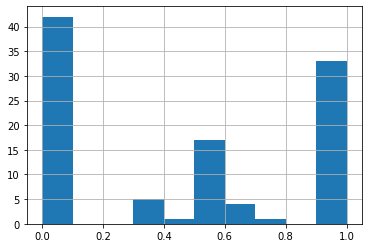

In [28]:
test_set.method_sci_recall.hist()

In [29]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.0,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,16.50,15.05,16.99,14.56,28.16,23.30,31.07,29.13,7406.80,7708.74,6966.99,10000.0,51.46,57.28,57.28,59.22,27.56,20.67,48.06,33.47,28.62,47.04,36.03,29.53,55.34,34.50,32.38,45.61
std,28.34,29.57,26.71,22.83,45.20,42.48,46.50,45.66,2566.88,2522.41,3785.30,0.0,50.22,49.71,49.71,49.38,29.48,24.30,48.52,32.25,30.19,44.78,35.98,33.55,49.02,32.92,34.38,43.02
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2500.00,2900.00,0.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4750.00,5000.00,4250.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7800.00,8800.00,10000.00,10000.0,100.00,100.00,100.00,100.00,25.00,16.67,50.00,40.00,33.33,50.00,40.00,25.00,100.00,40.00,33.33,50.00
75%,50.00,0.00,50.00,50.00,100.00,0.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,50.00,33.33,100.00,50.00,45.00,100.00,66.67,50.00,100.00,57.14,50.00,100.00
max,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [29]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.0,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,16.50,15.05,16.99,14.56,28.16,23.30,31.07,29.13,7406.80,7708.74,6966.99,10000.0,51.46,57.28,57.28,58.25,27.56,20.67,48.06,33.09,28.14,46.72,36.03,29.53,55.34,34.18,32.22,44.97
std,28.34,29.57,26.71,22.83,45.20,42.48,46.50,45.66,2566.88,2522.41,3785.30,0.0,50.22,49.71,49.71,49.56,29.48,24.30,48.52,31.93,29.42,44.75,35.98,33.55,49.02,33.09,34.65,42.95
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2500.00,2900.00,0.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4750.00,5000.00,4250.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7800.00,8800.00,10000.00,10000.0,100.00,100.00,100.00,100.00,25.00,16.67,50.00,40.00,33.33,50.00,40.00,25.00,100.00,40.00,28.57,50.00
75%,50.00,0.00,50.00,50.00,100.00,0.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,50.00,33.33,100.00,50.00,45.00,100.00,66.67,50.00,100.00,57.14,50.00,100.00
max,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [33]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.0,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,16.50,15.05,16.99,14.56,28.16,23.30,31.07,29.13,7406.80,7708.74,6966.99,10000.0,51.46,57.28,57.28,58.25,27.56,20.67,48.06,33.09,28.14,46.72,36.03,29.53,55.34,34.18,32.22,44.97
std,28.34,29.57,26.71,22.83,45.20,42.48,46.50,45.66,2566.88,2522.41,3785.30,0.0,50.22,49.71,49.71,49.56,29.48,24.30,48.52,31.93,29.42,44.75,35.98,33.55,49.02,33.09,34.65,42.95
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2500.00,2900.00,0.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4750.00,5000.00,4250.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7800.00,8800.00,10000.00,10000.0,100.00,100.00,100.00,100.00,25.00,16.67,50.00,40.00,33.33,50.00,40.00,25.00,100.00,40.00,28.57,50.00
75%,50.00,0.00,50.00,50.00,100.00,0.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,50.00,33.33,100.00,50.00,45.00,100.00,66.67,50.00,100.00,57.14,50.00,100.00
max,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [29]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.0,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,15.53,15.05,16.99,14.56,26.21,23.30,31.07,29.13,7343.69,7708.74,6966.99,10000.0,48.54,57.28,57.28,58.25,25.94,19.34,45.63,33.09,28.14,46.72,36.03,29.53,55.34,33.86,31.90,44.64
std,28.03,29.57,26.71,22.83,44.19,42.48,46.50,45.66,2520.57,2522.41,3785.30,0.0,50.22,49.71,49.71,49.56,29.11,23.89,48.62,31.93,29.42,44.75,35.98,33.55,49.02,32.93,34.48,42.91
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2500.00,2900.00,0.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4700.00,5000.00,4250.00,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7400.00,8800.00,10000.00,10000.0,0.00,100.00,100.00,100.00,0.00,0.00,0.00,40.00,33.33,50.00,40.00,25.00,100.00,40.00,28.57,50.00
75%,50.00,0.00,50.00,50.00,100.00,0.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,50.00,33.33,100.00,50.00,45.00,100.00,66.67,50.00,100.00,53.57,50.00,100.00
max,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [22]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,org_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,correct_org,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,org_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,correct_ratio_org,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall,org_f1,org_precision,org_recall
count,7200.00,7200.00,7200.00,7200.00,3900.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.0,3900.0,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,3900.00,3900.00,3900.00
mean,18.06,17.36,19.44,11.81,30.77,33.33,26.39,33.33,23.61,26.39,8237.50,8344.44,6711.11,0.0,10000.0,63.89,65.28,54.17,59.72,43.06,34.23,25.83,58.10,35.09,34.61,39.95,31.64,25.86,49.77,29.91,32.03,35.80,56.78,51.19,73.29
std,26.94,31.58,29.74,21.38,35.57,47.47,44.38,47.47,42.77,44.38,2329.63,2185.28,3916.26,0.0,0.0,48.37,47.94,50.18,49.39,49.86,28.39,23.63,46.81,30.65,31.76,36.66,32.61,29.73,48.25,27.85,33.17,36.21,35.72,36.72,40.56
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3100.00,2900.00,0.00,0.0,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6375.00,6700.00,4125.00,0.0,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33,20.19,50.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10000.00,10000.00,9700.00,0.0,10000.0,100.00,100.00,100.00,100.00,0.00,40.00,33.33,100.00,40.00,33.33,33.33,33.33,20.00,50.00,33.33,30.95,33.33,66.67,50.00,100.00
75%,50.00,50.00,50.00,0.00,50.00,100.00,100.00,100.00,0.00,100.00,10000.00,10000.00,10000.00,0.0,10000.0,100.00,100.00,100.00,100.00,100.00,50.00,33.33,100.00,51.79,66.67,66.67,51.79,50.00,100.00,50.00,50.00,54.17,85.71,87.50,100.00
max,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,0.0,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [22]:
(test_set.describe()*100).round(2)

,task_p_at_2,method_p_at_2,task_sci_p_at_2,method_sci_p_at_2,org_p_at_2,correct_task,correct_method,correct_sci_task,correct_sci_method,correct_org,task_ratio,method_ratio,task_sci_ratio,method_sci_ratio,org_ratio,correct_ratio_task,correct_ratio_method,correct_ratio_sci_task,correct_ratio_sci_method,correct_ratio_org,task_f1,task_precision,task_recall,method_f1,method_precision,method_recall,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall,org_f1,org_precision,org_recall
count,7200.00,7200.00,7200.00,7200.00,3900.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.0,3900.0,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,7200.00,3900.00,3900.00,3900.00
mean,18.06,17.36,17.36,13.19,30.77,33.33,26.39,33.33,22.22,26.39,8237.50,8344.44,8290.28,0.0,10000.0,63.89,65.28,75.00,69.44,43.06,34.23,25.83,58.10,35.09,34.61,39.95,36.26,27.43,68.29,33.96,31.17,47.70,56.78,51.19,73.29
std,26.94,31.58,25.40,26.53,35.57,47.47,44.38,47.47,41.87,44.38,2329.63,2185.28,3061.44,0.0,0.0,48.37,47.94,43.61,46.39,49.86,28.39,23.63,46.81,30.65,31.76,36.66,25.28,22.00,43.08,26.81,29.39,38.75,35.72,36.72,40.56
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3100.00,2900.00,0.00,0.0,10000.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6375.00,6700.00,7700.00,0.0,10000.0,0.00,0.00,75.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.50,6.82,25.00,0.00,0.00,0.00,33.33,20.19,50.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10000.00,10000.00,10000.00,0.0,10000.0,100.00,100.00,100.00,100.00,0.00,40.00,33.33,100.00,40.00,33.33,33.33,40.00,25.00,100.00,34.85,30.95,50.00,66.67,50.00,100.00
75%,50.00,50.00,50.00,0.00,50.00,100.00,100.00,100.00,0.00,100.00,10000.00,10000.00,10000.00,0.0,10000.0,100.00,100.00,100.00,100.00,100.00,50.00,33.33,100.00,51.79,66.67,66.67,57.14,50.00,100.00,55.19,50.00,81.25,85.71,87.50,100.00
max,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,10000.00,10000.00,10000.00,0.0,10000.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,80.00,100.00,100.00,85.71,100.00,100.00,100.00,100.00,100.00
